# Routing

This notebook shows how to import and use erde.routing module from Python code.

## 1. Routers Settings

First, let's make a config file to store routers URLs there.

In [1]:
import yaml

config = {'routers': {'foot': 'https://routing.openstreetmap.de/routed-foot'}}
with open('./erde.yml', 'w') as f:
    yaml.dump(config, f)

Erde loads config files when imported, so this should be done beforehand.

## 2. Imports

In [2]:
from erde import route, read_df, CONFIG

Let's check the config.

In [3]:
CONFIG['routers']

{'local': 'http://localhost:5000',
 'foot': 'https://routing.openstreetmap.de/routed-foot'}

Default config has only a `'local'` router as an example, but now our router URL is also loaded from current directory. Now we can use `'foot'` as a shortcut rather than write the entire URL.

Let's load the directions file.

<AxesSubplot:>

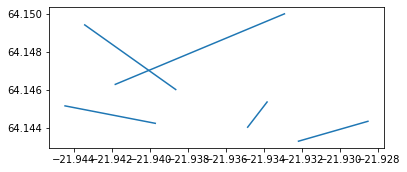

In [4]:
dirs = read_df('reykjavik-directions.csv')
dirs.plot()

On map the directions dataframe should look like this: (rendered with QGIS)

![Directions](./reyk-directions.jpg)

## 3. Routing
Let's call the router:

<AxesSubplot:>

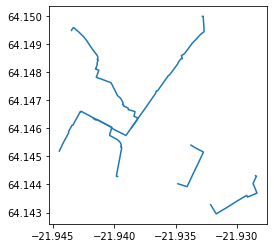

In [5]:
res = route(dirs, 'foot')
res.plot()

We can also call a router with a URL that's not in the config:

<AxesSubplot:>

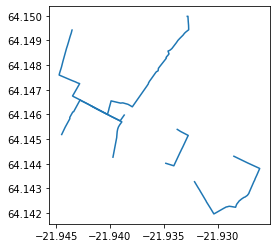

In [6]:
res_bike = route(dirs, 'https://routing.openstreetmap.de/routed-bike')
res_bike.plot()

As you see, routes with bike are slightly different.

How it may look in QGIS with some styling and background:

![Routes on map](./reyk-routes.jpg)

Comparing the `dirs` and `res` dataframes:

In [7]:
dirs.head(2)

,rid,name,geometry
0,1,A,"LINESTRING (-21.93489 64.14400, -21.93382 64.1..."
1,2,B,"LINESTRING (-21.92850 64.14436, -21.93223 64.1..."


In [8]:
res.head(2)

,rid,name,alternative,duration,distance,geometry
0,1,A,1,202.3,252.8,"LINESTRING (-21.93487 64.14403, -21.93406 64.1..."
1,2,B,1,252.4,315.3,"LINESTRING (-21.92854 64.14432, -21.92840 64.1..."


## 4. Alternatives

OSRM server can return multiple alternative routes. Let's request 3.

In [9]:
res2 = route(dirs, 'foot', alternatives=3)

In [10]:
res2

,rid,name,alternative,duration,distance,geometry
0,1,A,1,202.3,252.8,"LINESTRING (-21.93487 64.14403, -21.93406 64.1..."
1,1,A,2,209.7,262.1,"LINESTRING (-21.93487 64.14403, -21.93548 64.1..."
2,2,B,1,252.4,315.3,"LINESTRING (-21.92854 64.14432, -21.92840 64.1..."
3,2,B,2,264.6,330.7,"LINESTRING (-21.92854 64.14432, -21.92866 64.1..."
4,3,C,1,444.0,555.2,"LINESTRING (-21.94451 64.14516, -21.94416 64.1..."
5,3,C,2,540.1,674.8,"LINESTRING (-21.94451 64.14516, -21.94563 64.1..."
6,4,D,1,461.1,576.7,"LINESTRING (-21.94351 64.14945, -21.94344 64.1..."
7,4,D,2,510.8,639.1,"LINESTRING (-21.94351 64.14945, -21.94351 64.1..."
8,4,D,3,524.4,656.0,"LINESTRING (-21.94351 64.14945, -21.94344 64.1..."
9,5,E,1,596.9,746.6,"LINESTRING (-21.93288 64.14997, -21.93275 64.1..."


As you can see, not all routes have 3 routes, some have just 2.

## 5. Playing with the results

Let's take attributes from the result dataframe and put them back into the original dataframe.

In [11]:
ridx = res.set_index('rid')

dirs['duration'] = dirs.rid.map(ridx['duration'])
dirs['distance'] = dirs.rid.map(ridx['distance'])

dirs

,rid,name,geometry,duration,distance
0,1,A,"LINESTRING (-21.93489 64.14400, -21.93382 64.1...",202.3,252.8
1,2,B,"LINESTRING (-21.92850 64.14436, -21.93223 64.1...",252.4,315.3
2,3,C,"LINESTRING (-21.94451 64.14516, -21.93969 64.1...",444.0,555.2
3,4,D,"LINESTRING (-21.94347 64.14944, -21.93862 64.1...",461.1,576.7
4,5,E,"LINESTRING (-21.93290 64.15001, -21.94186 64.1...",596.9,746.6


In [12]:
ridx2 = res2.groupby('rid').agg({'duration': 'mean', 'distance': 'mean'})
dirs['mean_duration'] = dirs.rid.map(ridx2.duration)
dirs['mean_distance'] = dirs.rid.map(ridx2.distance)
dirs

,rid,name,geometry,duration,distance,mean_duration,mean_distance
0,1,A,"LINESTRING (-21.93489 64.14400, -21.93382 64.1...",202.3,252.8,206.000000,257.450000
1,2,B,"LINESTRING (-21.92850 64.14436, -21.93223 64.1...",252.4,315.3,258.500000,323.000000
2,3,C,"LINESTRING (-21.94451 64.14516, -21.93969 64.1...",444.0,555.2,492.050000,615.000000
3,4,D,"LINESTRING (-21.94347 64.14944, -21.93862 64.1...",461.1,576.7,498.766667,623.933333
4,5,E,"LINESTRING (-21.93290 64.15001, -21.94186 64.1...",596.9,746.6,632.900000,791.650000


The directions geometries are still the original:

<AxesSubplot:>

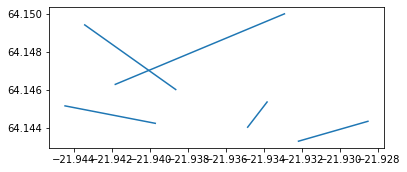

In [13]:
dirs.plot()

Let's calculate the ratio of travel distance: length of route to length of direct line.

In [14]:
from erde import length

dirs.crs = 4326
dirs = length(dirs)
dirs

,rid,name,geometry,duration,distance,mean_duration,mean_distance,length
0,1,A,"LINESTRING (-21.93489 64.14400, -21.93382 64.1...",202.3,252.8,206.000000,257.450000,162.886785
1,2,B,"LINESTRING (-21.92850 64.14436, -21.93223 64.1...",252.4,315.3,258.500000,323.000000,216.581687
2,3,C,"LINESTRING (-21.94451 64.14516, -21.93969 64.1...",444.0,555.2,492.050000,615.000000,256.096335
3,4,D,"LINESTRING (-21.94347 64.14944, -21.93862 64.1...",461.1,576.7,498.766667,623.933333,449.905515
4,5,E,"LINESTRING (-21.93290 64.15001, -21.94186 64.1...",596.9,746.6,632.900000,791.650000,602.338816


In [15]:
dirs['indirectness_ratio'] = dirs['distance'] / dirs['length']
dirs

,rid,name,geometry,duration,distance,mean_duration,mean_distance,length,indirectness_ratio
0,1,A,"LINESTRING (-21.93489 64.14400, -21.93382 64.1...",202.3,252.8,206.000000,257.450000,162.886785,1.551998
1,2,B,"LINESTRING (-21.92850 64.14436, -21.93223 64.1...",252.4,315.3,258.500000,323.000000,216.581687,1.455802
2,3,C,"LINESTRING (-21.94451 64.14516, -21.93969 64.1...",444.0,555.2,492.050000,615.000000,256.096335,2.167934
3,4,D,"LINESTRING (-21.94347 64.14944, -21.93862 64.1...",461.1,576.7,498.766667,623.933333,449.905515,1.281825
4,5,E,"LINESTRING (-21.93290 64.15001, -21.94186 64.1...",596.9,746.6,632.900000,791.650000,602.338816,1.239502


Route C has the highest ratio, because it goes around the lake:

![Route C](./reyk-routes.jpg)